In [1]:
import os
# import spacy
import warnings
# import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
patient_notes = pd.read_csv('../dataset/patient_notes.csv')
features = pd.read_csv('../dataset/features.csv')
sample_submission = pd.read_csv('../dataset/sample_submission.csv')

8      1
12     1
15     1
17     1
21     2
      ..
186    1
188    2
189    3
192    1
194    1
Name: pn_history, Length: 167, dtype: int64

30        1
72        1
75        1
108       1
127       1
       ... 
946     787
947     967
948    1203
949    1618
950    2395
Name: pn_history, Length: 710, dtype: int64
2395 950


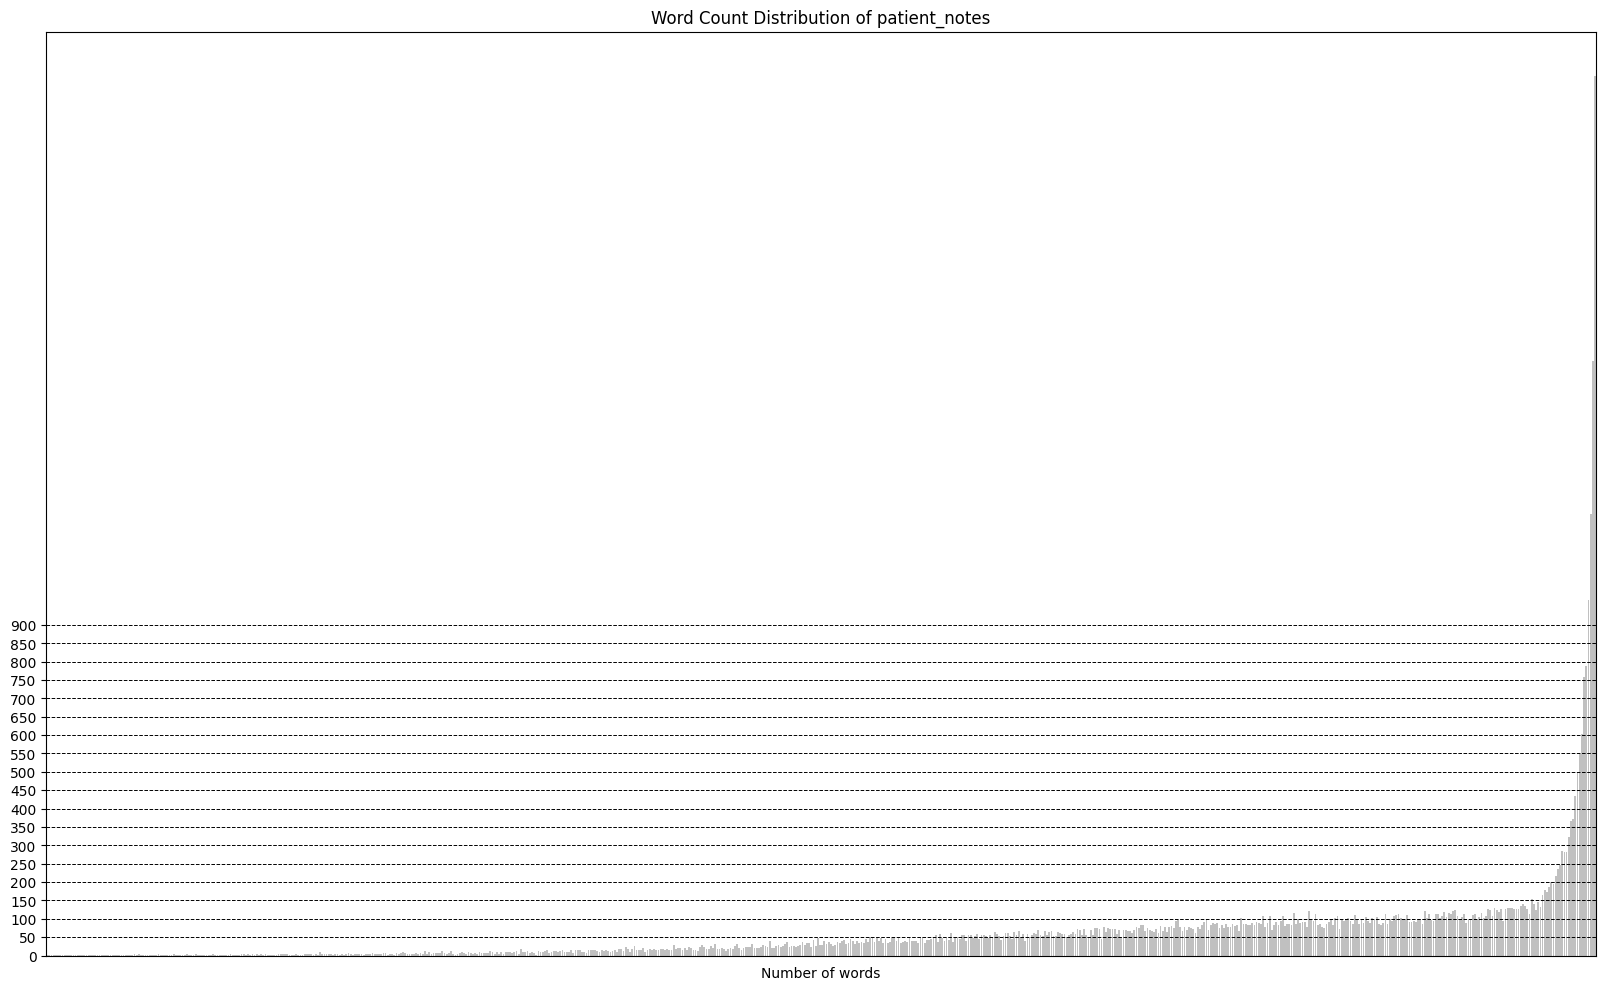

In [7]:
text_len1 = patient_notes['pn_history'].map(lambda x : len(x))
text_len_counts1 = text_len1.value_counts().sort_index()
print(text_len_counts1)
max_count = text_len_counts1.max()
max_index = text_len_counts1.idxmax()
print(max_count,max_index)

plt.figure(figsize=(20, 12))
sns.barplot(x=text_len_counts1.index, y=text_len_counts1.values, color='silver')
plt.xticks([])
plt.title('Word Count Distribution of patient_notes')
plt.xlabel('Number of words')
plt.ylabel('',rotation=0,labelpad=25)
plt.yticks(range(0, 900 + 50, 50))
plt.grid(axis='y', linestyle='--', linewidth=0.7,color='black')

plt.show()

Data shape

Train

In [3]:
print(f'\033[92mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[91mNumber of values in train data: {train.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(train.isna().sum())}')
train.head()

Number of rows in train data: 14300
Number of columns in train data: 6
Number of values in train data: 85800
Number missing values in train data: 0


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [4]:
patient_notes[patient_notes['pn_num']==16]

,pn_num,case_num,pn_history
16,16,0,HPI: 17yo M presents with palpitations. Patien...


In [5]:
train[train['pn_num']==16]

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
5,00016_005,0,16,5,[],[]
6,00016_006,0,16,6,"['adderall', 'adderrall', 'adderrall']","['321 329', '404 413', '652 661']"
7,00016_007,0,16,7,[],[]
8,00016_008,0,16,8,[],[]
9,00016_009,0,16,9,"['palpitations', 'heart beating/pounding']","['26 38', '96 118']"


In [6]:
train["location"] = train["location"].apply(eval)
train['annotation'] = train['annotation'].apply(eval)
train["annot_count"] = 0
for i in range(len(train)):
    train["annot_count"][i] = len(train["annotation"][i])
total_annot = 0
for idx in train["annot_count"].value_counts().sort_index().index:
    total_annot += train["annot_count"].value_counts().sort_index()[idx] * idx
print(f'\033[92mTotal number of Annotations is train data  : ' , total_annot)
print(f'\033[94mAnnotation count per row: ')
print(f'\033[94m',train["annot_count"].value_counts().sort_index())

C:\Users\0122h\AppData\Local\Temp\ipykernel_13540\3016788510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["annot_count"][i] = len(train["annotation"][i])


Total number of Annotations is train data  :  12234
Annotation count per row: 
 0    4399
1    8181
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64


Test

In [7]:
print(f'\033[92mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[91mNumber of values in train data: {test.count().sum()}')
print(f'\033[91mNo of rows with missing values  in test data: {sum(test.isna().sum())}')
test.head()

Number of rows in test data: 5
Number of columns in test data: 4
Number of values in train data: 20
No of rows with missing values  in test data: 0


,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


Patient notes

In [8]:
print(f'\033[92mNumber of rows in test data: {patient_notes.shape[0]}')
print(f'\033[94mNumber of columns in test data: {patient_notes.shape[1]}')
print(f'\033[91mNumber of values in train data: {patient_notes.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(patient_notes.isna().sum())}')
patient_notes.head()

Number of rows in test data: 42146
Number of columns in test data: 3
Number of values in train data: 126438
Number missing values in train data: 0


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [19]:
features.groupby('case_')

<bound method DataFrame.groupby of      feature_num  case_num                                       feature_text
0              0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1              1         0                 Family-history-of-thyroid-disorder
2              2         0                                     Chest-pressure
3              3         0                              Intermittent-symptoms
4              4         0                                        Lightheaded
..           ...       ...                                                ...
138          912         9                        Family-history-of-migraines
139          913         9                                             Female
140          914         9                                        Photophobia
141          915         9                          No-known-illness-contacts
142          916         9                                   Subjective-fever

[143 rows x 3 columns]>

In [9]:
notes_counts = patient_notes.groupby("case_num").count()
notes_counts

,pn_num,pn_history
case_num,,
0,2268,2268
1,808,808
2,1958,1958
3,9753,9753
4,5405,5405
5,6909,6909
6,1597,1597
7,4101,4101
8,4196,4196


(array([[1., 1., 0., 1., 2., 0., 0., 1., 2., 2.],
        [1., 1., 0., 1., 2., 0., 0., 1., 2., 2.]]),
 array([ 9. ,  9.9, 10.8, 11.7, 12.6, 13.5, 14.4, 15.3, 16.2, 17.1, 18. ]),
 <a list of 2 BarContainer objects>)

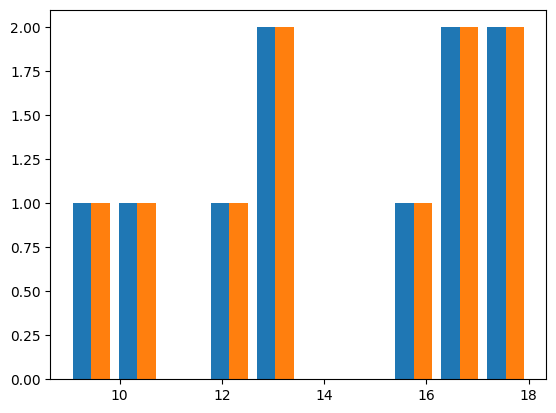

In [14]:
fea_g = features.groupby("case_num")
# plt.hist(fea_g)

In [10]:
# plt.bar(patient_notes,height=10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

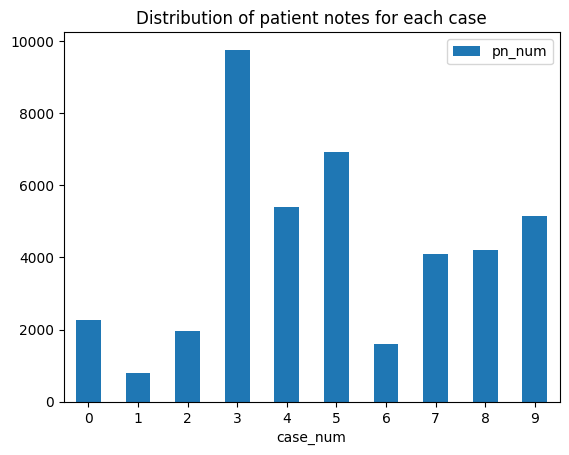

In [23]:
fig = notes_counts.plot.bar(y='pn_num'
                            ,title='Distribution of patient notes for each case'
                        )
plt.xticks(rotation=0)



ValueError: Invalid color p

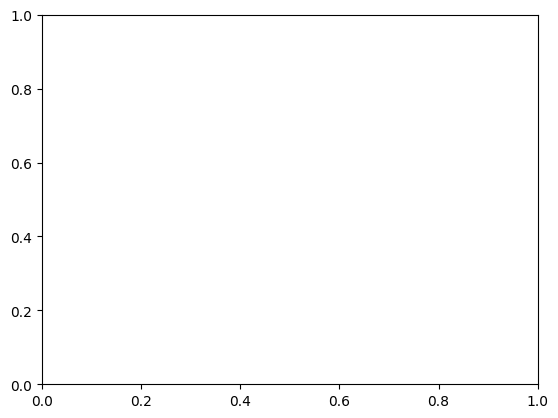

In [12]:
# notes_counts = patient_notes.groupby("case_num").count()
# notes_counts = pd.DataFrame(notes_counts)
fig = notes_counts.plot(kind='bar',
        #      x = notes_counts.index.name,
        #      y = 'pn_num' ,
             color = "pn_num",
             color_continuous_scale="Emrld")
fig.update_layout(title = {
        'text': 'Distribution of patient notes for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1,2, 3, 4,5, 6,7,8,9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template = "plotly_white")
fig.show()

Features

In [ ]:
print(features.shape)
features.head()

(143, 3)


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


EDA